<a href="https://colab.research.google.com/github/gmarchetti2020/ps-training/blob/main/9_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Tutorial
Long & Short-Term Memory (LSTM) networks are designed to learn and remember dependencies in sequences of inputs presented to them. They are especially suited to problems where the data is a function of time, and patterns exist in sequences of values, for example:
- Time series forecasting
- Sentence or sentiment classification
- Translation
- Chatbots
In this tutorial we are focusing on forecasting a time series with 1 variable (aka univariate).

#### Acknowledgement
This notebook is derived from Jason Brownlee's article at https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ 

### Problem Statement
We have historical data about the number of international airline passengers between January 1949 and December 1960. The data is aggregated by month and measured in thousands, so we'll have 144 data points. We want to forecast the number of passengers.

In [ ]:
%pip install fsspec gcsfs

     |████████████████████████████████| 92kB 3.1MB/s 
     |████████████████████████████████| 1.2MB 9.4MB/s 
     |████████████████████████████████| 266kB 34.6MB/s 
     |████████████████████████████████| 153kB 36.2MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3161 sha256=9b3648805955d074421c8c9abbfbd9b80da4296d8e73324afedae0bf4f8118cc
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv('gs://ps_workshop_files/AirPassengers.csv')
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


The input is regular every month and has no missing time steps, so we don't really need the month column. The index 0-143 is sufficient to represent the time steps.

In [ ]:
df=df.drop('Month', axis=1)
df

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


### Plot input data

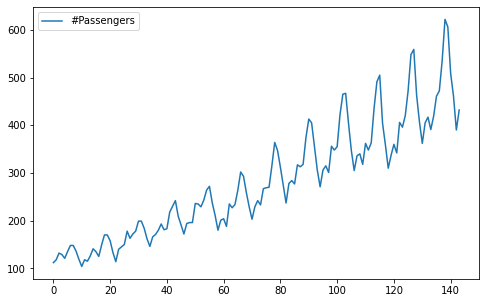

In [ ]:
df.plot(figsize=(8,5))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1601e42278>]],
      dtype=object)

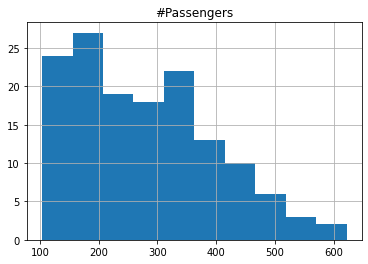

In [ ]:
df.hist(bins=10)

We notice that there is a trend and a multiplicative seasonality: the pattern repeats and is also amplified over time.

### Regression over time
We can think of forecasting as of a regression problem: given the number of passengers this month, how many will there be next month?  
The time series is univariate (we have only one variable) and in this case we consider a time lag (aka look-back) of 1 step.

In [ ]:
# Import all the libraries required.
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#### Normalize the data set
LSTMs are sensitive to the scale of the input data, because they use the sigmoid and activation functions. Hence, we rescale the data to [0,1].  
We can use the MinMaxScaler to perform a linear normalization.


In [ ]:
# The dataset consists of only the numbers in our dataframe (no column names). We normalize it into [0,1]
dataset = df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#### Split the data into training and testing sets
With time series, we cannot just take a random sample to train or test on. We split the dataset while maintaining the chronological order. The "older" part will be used for training, the newer one for testing.

In [ ]:
# split into train and test sets
TRAIN_PC=0.7 # percentage to train on

train_size = int(len(dataset) * TRAIN_PC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

100 44


To train a neural network for regression, we need to provide an input X and an output Y.  
In our case the output at time t is determined by the input at time t-1. In other words, the output is the input shifted back by a given lag value. The lag is often referred to as "look-back".

In [ ]:
# target index is the column n. that contains the target variable to be predicted. In our case we have 1 column, so it is 0. 
# lag is how far back we need to shift to train, or how far forward we need to predict.
def create_xy(dataset, target_index, lag=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-lag-1):
        a = dataset[i:(i+lag), target_index]
        dataX.append(a)
        dataY.append(dataset[i + lag, target_index])
    return np.array(dataX), np.array(dataY)

In [ ]:
LAG = 1
TARGET_INDEX=0

trainX, trainY = create_xy(train, TARGET_INDEX, LAG)
testX, testY = create_xy(test, TARGET_INDEX, LAG)

In [ ]:
trainX.shape

(98, 1)

In [ ]:
trainX

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123553],
       [0.04247104],
       [0.07142857],
       [0.05984557],
       [0.04054055],
       [0.08687258],
       [0.12741312],
       [0.12741312],
       [0.10424709],
       [0.05598456],
       [0.01930502],
       [0.06949806],
       [0.07915059],
       [0.08880308],
       [0.14285713],
       [0.11389962],
       [0.13127413],
       [0.14285713],
       [0.18339768],
       [0.18339768],
       [0.15444016],
       [0.11196911],
       [0.08108109],
       [0.1196911 ],
       [0.12934363],
       [0.14671814],
       [0.17181468],
       [0.14864865],
       [0.15250966],
       [0.22007722],
       [0.24324325],
       [0.26640925],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

The LSTM network block in Keras requires the input X to be shaped as an array with: [n. of. samples, time steps, n. of features].  
Our data is in the form: [n. of samples, n. of features] and we have one time step for each sample.   
We can reshape the data with numpy.

In [ ]:
# reshape input to be [n. of samples, time steps, n. of features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX

array([[[0.01544401]],

       [[0.02702703]],

       [[0.05405405]],

       [[0.04826255]],

       [[0.03281853]],

       [[0.05984557]],

       [[0.08494207]],

       [[0.08494207]],

       [[0.06177607]],

       [[0.02895753]],

       [[0.        ]],

       [[0.02702703]],

       [[0.02123553]],

       [[0.04247104]],

       [[0.07142857]],

       [[0.05984557]],

       [[0.04054055]],

       [[0.08687258]],

       [[0.12741312]],

       [[0.12741312]],

       [[0.10424709]],

       [[0.05598456]],

       [[0.01930502]],

       [[0.06949806]],

       [[0.07915059]],

       [[0.08880308]],

       [[0.14285713]],

       [[0.11389962]],

       [[0.13127413]],

       [[0.14285713]],

       [[0.18339768]],

       [[0.18339768]],

       [[0.15444016]],

       [[0.11196911]],

       [[0.08108109]],

       [[0.1196911 ]],

       [[0.12934363]],

       [[0.14671814]],

       [[0.17181468]],

       [[0.14864865]],

       [[0.15250966]],

       [[0.22007

In [ ]:
trainX.shape

(98, 1, 1)

#### Design the LSTM network

We build a network with 1 input, a hidden layer with 4 LSTM blocks, and an output layer with one output.  
We use the the default sigmoid activation function for the LSTM blocks.  
Given the small size of the data, we set a batch size of 1 and train for 100 epochs.

In [ ]:
# create the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, LAG)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# train the network
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0457
Epoch 2/100
98/98 [==============================] - 0s 3ms/step - loss: 0.0230
Epoch 3/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0175
Epoch 4/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0158
Epoch 5/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0149
Epoch 6/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0140
Epoch 7/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0132
Epoch 8/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 9/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 10/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 11/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 12/100
98/98 [==============================] - 0s 1ms/step - loss: 0.0093
Epoch 13/100
98/98 [=================

Now we want to extract the network predictions on both the train and test sets, then measure its regression performance. The predictions will be normalized in [0.1], so we need to de-normalize them in order to compare them with the original data set.  
For performance measurement, we'll use both the root-mean-squared error and the coefficient of determination (aka R2 score).


In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# de-normalize predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error and coefficient of determination
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
r2trainScore=r2_score(trainY[0], trainPredict[:,0])
print('Train Score: RMSE = %.2f, R2 = %2f' % (trainScore, r2trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
r2testScore=r2_score(testY[0], testPredict[:,0])
print('Test Score: RMSE = %.2f, R2 = %.2f' % (testScore, r2testScore))

Train Score: RMSE = 23.27, R2 = 0.897362
Test Score: RMSE = 49.64, R2 = 0.59


We can see that the model did a good job of fitting the training set, not as good on the test set.
#### Plot the results

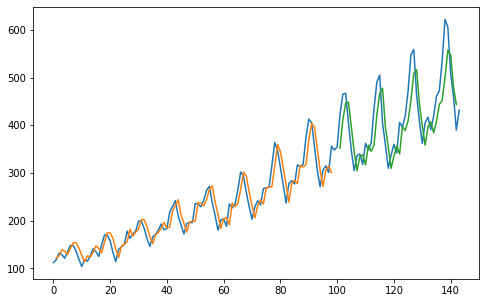

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[LAG:len(trainPredict)+LAG, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(LAG*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(8,5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Using a window of past features
So far, we have considered only the current input to predict one time step ahead. That is often not sufficient to capture all the information we need. We can use a window of past time steps to compute a future one. For example, the value at time t+1 may depend on the values at times t, t-1, t-2. 
In other words, we want to use a lag=3.  
The lag is a parameter that will need to be tuned for the problem at hand.

In [ ]:
LAG = 3
trainX, trainY = create_xy(train, 0, LAG)
testX, testY = create_xy(test, 0, LAG)
trainX

array([[0.01544401, 0.02702703, 0.05405405],
       [0.02702703, 0.05405405, 0.04826255],
       [0.05405405, 0.04826255, 0.03281853],
       [0.04826255, 0.03281853, 0.05984557],
       [0.03281853, 0.05984557, 0.08494207],
       [0.05984557, 0.08494207, 0.08494207],
       [0.08494207, 0.08494207, 0.06177607],
       [0.08494207, 0.06177607, 0.02895753],
       [0.06177607, 0.02895753, 0.        ],
       [0.02895753, 0.        , 0.02702703],
       [0.        , 0.02702703, 0.02123553],
       [0.02702703, 0.02123553, 0.04247104],
       [0.02123553, 0.04247104, 0.07142857],
       [0.04247104, 0.07142857, 0.05984557],
       [0.07142857, 0.05984557, 0.04054055],
       [0.05984557, 0.04054055, 0.08687258],
       [0.04054055, 0.08687258, 0.12741312],
       [0.08687258, 0.12741312, 0.12741312],
       [0.12741312, 0.12741312, 0.10424709],
       [0.12741312, 0.10424709, 0.05598456],
       [0.10424709, 0.05598456, 0.01930502],
       [0.05598456, 0.01930502, 0.06949806],
       [0.

In [ ]:
trainX.shape

(96, 3)

When using the window method, we have as many features as the lag value for each prediction

In [ ]:
# reshape input to be [n. of samples, time steps, n. of features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX

array([[[0.01544401, 0.02702703, 0.05405405]],

       [[0.02702703, 0.05405405, 0.04826255]],

       [[0.05405405, 0.04826255, 0.03281853]],

       [[0.04826255, 0.03281853, 0.05984557]],

       [[0.03281853, 0.05984557, 0.08494207]],

       [[0.05984557, 0.08494207, 0.08494207]],

       [[0.08494207, 0.08494207, 0.06177607]],

       [[0.08494207, 0.06177607, 0.02895753]],

       [[0.06177607, 0.02895753, 0.        ]],

       [[0.02895753, 0.        , 0.02702703]],

       [[0.        , 0.02702703, 0.02123553]],

       [[0.02702703, 0.02123553, 0.04247104]],

       [[0.02123553, 0.04247104, 0.07142857]],

       [[0.04247104, 0.07142857, 0.05984557]],

       [[0.07142857, 0.05984557, 0.04054055]],

       [[0.05984557, 0.04054055, 0.08687258]],

       [[0.04054055, 0.08687258, 0.12741312]],

       [[0.08687258, 0.12741312, 0.12741312]],

       [[0.12741312, 0.12741312, 0.10424709]],

       [[0.12741312, 0.10424709, 0.05598456]],

       [[0.10424709, 0.05598456, 0.01930

In [ ]:
trainX.shape

(96, 1, 3)

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, LAG)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# train the network
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0534
Epoch 2/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0185
Epoch 3/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 4/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 5/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0085
Epoch 6/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0071
Epoch 7/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 8/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 9/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 10/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 11/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 12/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 13/100
96/96 [=================

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# de-normalize predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error and coefficient of determination
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
r2trainScore=r2_score(trainY[0], trainPredict[:,0])
print('Train Score: RMSE = %.2f, R2 = %2f' % (trainScore, r2trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
r2testScore=r2_score(testY[0], testPredict[:,0])
print('Test Score: RMSE = %.2f, R2 = %.2f' % (testScore, r2testScore))

Train Score: RMSE = 23.93, R2 = 0.889949
Test Score: RMSE = 48.40, R2 = 0.63


The score is slightly better on the test set. More tuning is required.

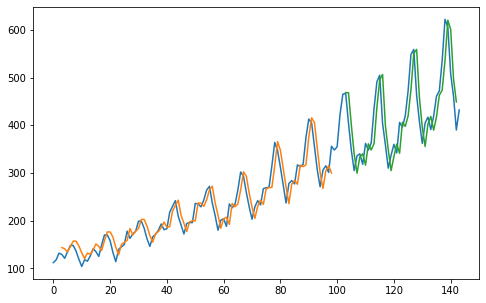

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[LAG:len(trainPredict)+LAG, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(LAG*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(8,5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Using a window of past time steps
The window we are using contains past time steps of the one feature we are trying to predict. Hence, the network input really needs only 1 feature but as many time steps as the lag value. We can represent this by reshaping our input arrays with numpy. The samples remain the number of rows of our input array, but the number of columns now represents the time steps for each sample and the feature number is 1.

In [ ]:
trainX, trainY = create_xy(train, 0, LAG)
testX, testY = create_xy(test, 0, LAG)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(LAG, 1))) # we swapped the dimension in our input arrays, so we swap in the input specification as well
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0236
Epoch 2/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 3/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 4/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 5/100
96/96 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 6/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 7/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 8/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 9/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 10/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 11/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 12/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 13/100
96/96 [=================

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error and coefficient of determination
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
r2trainScore=r2_score(trainY[0], trainPredict[:,0])
print('Train Score: RMSE = %.2f, R2 = %2f' % (trainScore, r2trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
r2testScore=r2_score(testY[0], testPredict[:,0])
print('Test Score: RMSE = %.2f, R2 = %.2f' % (testScore, r2testScore))

Train Score: RMSE = 24.44, R2 = 0.885183
Test Score: RMSE = 58.11, R2 = 0.46


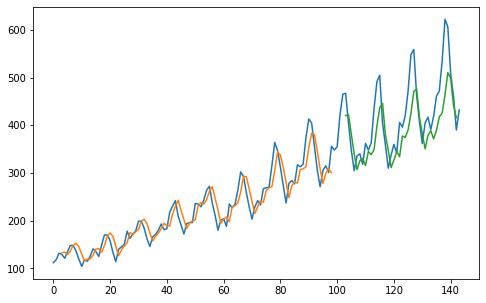

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[LAG:len(trainPredict)+LAG, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(LAG*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(8,5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

We can see that the results are about the same as previous example on training, worse on test. The structure of the input data makes more sense, but seems to cause some overfitting.

### LSTM with memory between batches
The LSTM network has memory, which makes it capable of remembering long input sequences. However, Keras normally resets the internal state of the network after each batch during training and after each call to model.predict or model.evaluate.
We can make the LSTM stateful, hence build an internal state over an entire epoch rather than just a batch. We can also maintain it for predictions.
For that to work, we must:
- Specify the stateful parameter to be True.
- Not shuffle the data when training.
- Reset the state after each epoch, as Keras won't do it for us.
- Specify a batch shape of [batch_size, steps, features].

In [ ]:
LAG = 3
trainX, trainY = create_xy(train, 0, LAG)
testX, testY = create_xy(test, 0, LAG)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
# create the LSTM network
BATCH_SIZE = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(BATCH_SIZE, LAG, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# train the network while maintaining state for each epoch. Reset after each epoch. 
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=BATCH_SIZE, verbose=1, shuffle=False)
    model.reset_states()

96/96 [==============================] - 0s 1ms/step - loss: 0.0017


In [ ]:
# make predictions
trainPredict = model.predict(trainX, batch_size=BATCH_SIZE)
model.reset_states()
testPredict = model.predict(testX, batch_size=BATCH_SIZE)

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error and coefficient of determination
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
r2trainScore=r2_score(trainY[0], trainPredict[:,0])
print('Train Score: RMSE = %.2f, R2 = %2f' % (trainScore, r2trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
r2testScore=r2_score(testY[0], testPredict[:,0])
print('Test Score: RMSE = %.2f, R2 = %.2f' % (testScore, r2testScore))

Train Score: RMSE = 21.79, R2 = 0.908724
Test Score: RMSE = 52.99, R2 = 0.55


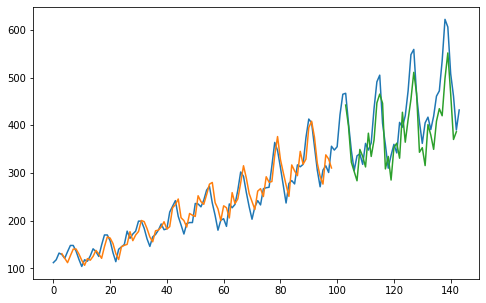

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[LAG:len(trainPredict)+LAG, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(LAG*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(8,5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Somewhat better results on training and test: The model may need more modules and may need to be trained for more epochs.

### Stacked LSTMs with memory between batches

To add modules, LSTM networks can be stacked in Keras. For that to work, each LSTM layer except the last one must return the sequence of its hidden states.

In [ ]:
LAG = 3
trainX, trainY = create_xy(train, 0, LAG)
testX, testY = create_xy(test, 0, LAG)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
# create the LSTM network
BATCH_SIZE = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(BATCH_SIZE, LAG, 1), stateful=True, return_sequences=True)) # return the sequence
model.add(LSTM(4, batch_input_shape=(BATCH_SIZE, LAG, 1), stateful=True, return_sequences=False)) # last LSTM need not return the sequence
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# train the network while maintaining state for each epoch. Reset after each epoch. 
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=BATCH_SIZE, verbose=1, shuffle=False)
    model.reset_states()

96/96 [==============================] - 0s 3ms/step - loss: 0.0019


In [ ]:
# make predictions
trainPredict = model.predict(trainX, batch_size=BATCH_SIZE)
model.reset_states()
testPredict = model.predict(testX, batch_size=BATCH_SIZE)

In [ ]:
# de-normalize predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error and coefficient of determination
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
r2trainScore=r2_score(trainY[0], trainPredict[:,0])
print('Train Score: RMSE = %.2f, R2 = %2f' % (trainScore, r2trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
r2testScore=r2_score(testY[0], testPredict[:,0])
print('Test Score: RMSE = %.2f, R2 = %.2f' % (testScore, r2testScore))

Train Score: RMSE = 22.31, R2 = 0.904339
Test Score: RMSE = 66.62, R2 = 0.29


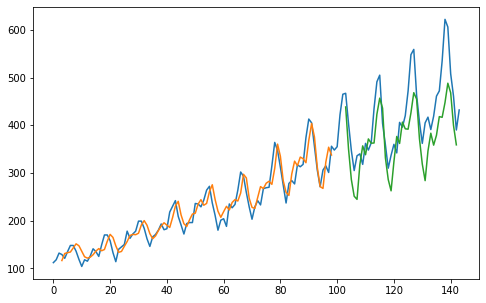

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[LAG:len(trainPredict)+LAG, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(LAG*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(8,5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

The predictions on the test dataset are again worse, but better on the training set. The network may be overfitting the training set - a common problem with LSTMs. We may need to introduce some regularization layers.

### And now a little trick
A little pre-processing may go a long way. Let us try and remove the multiplicative component. This can be done simply by applying the logarithm function. In fact log(a*b)=log(a)+log(b).
We can then reverse the transformation by applying the exponential function exp().

In [ ]:
# The dataset consists of the log of our values. We normalize it into [0,1]
dataset = np.log(df.values)
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

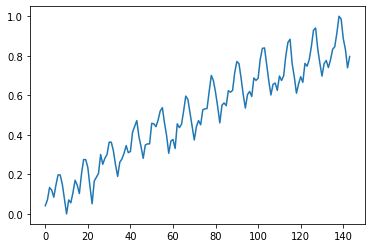

In [ ]:
plt.plot(dataset)

In [ ]:
# split into train and test sets
TRAIN_PC=0.7 # percentage to train on

train_size = int(len(dataset) * TRAIN_PC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

100 44


In [ ]:
# create features and labels
LAG = 3
trainX, trainY = create_xy(train, 0, LAG)
testX, testY = create_xy(test, 0, LAG)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

Now we create a simple network - no fancy memory between batches, state reset etc...

In [ ]:
# create the LSTM network
model = Sequential()
model.add(LSTM(4, 
               stateful=False, 
               return_sequences=False)) # last LSTM need not return the sequence
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# train the network 
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=1)

Epoch 1/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0244
Epoch 2/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0091
Epoch 3/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0080
Epoch 4/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 5/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 6/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 7/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 8/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 9/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 10/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 11/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 12/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 13/200
96/96 [=================

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
# invert predictions and the log transformation
trainPredict = np.exp(scaler.inverse_transform(trainPredict))
trainY = np.exp(scaler.inverse_transform([trainY]))
testPredict = np.exp(scaler.inverse_transform(testPredict))
testY = np.exp(scaler.inverse_transform([testY]))

In [ ]:
# calculate root mean squared error and coefficient of determination
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
r2trainScore=r2_score(trainY[0], trainPredict[:,0])
print('Train Score: RMSE = %.2f, R2 = %2f' % (trainScore, r2trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
r2testScore=r2_score(testY[0], testPredict[:,0])
print('Test Score: RMSE = %.2f, R2 = %.2f' % (testScore, r2testScore))

Train Score: RMSE = 22.06, R2 = 0.906422
Test Score: RMSE = 45.30, R2 = 0.67


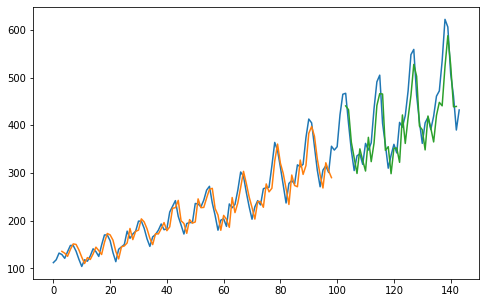

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[LAG:len(trainPredict)+LAG, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(LAG*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(8,5))
plt.plot(np.exp(scaler.inverse_transform(dataset)))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Thus we get a good result with a very simple network.